In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

import summarize

In [2]:
df = pd.read_csv('fitbit/tidy.csv')

In [3]:
# We decided to remove the food logs because they were mostly 0

In [4]:
df.head(5)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [5]:
summarize.df_summary(df)

--- Shape: (225, 10)
--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null object
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB
--- Descriptions
            date calories_burned steps    distance      floors  \
count        225             225   225  225.000000  225.000000   
unique       225             207   213         NaN         NaN   
top     11/27/18           2,145     0         NaN         NaN   
freq           1               4    12         NaN         NaN  

In [6]:
# change date to datetime
# remove commas to change to numeric dtypes

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df = df.set_index(df['date'])

In [9]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,,
2018-04-26,2018-04-26,"2,635","2,931",1.38,2,"1,347",93,0,0,566
2018-04-27,2018-04-27,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2018-04-28,2018-04-28,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
2018-04-29,2018-04-29,"2,851","1,639",0.77,0,891,122,0,0,602
2018-04-30,2018-04-30,"2,825","1,323",0.62,0,880,104,0,0,540


In [10]:
df['calories_burned'] = df['calories_burned'].str.replace(',','')
df['steps'] = df['steps'].str.replace(',','')
df['minutes_sedentary'] = df['minutes_sedentary'].str.replace(',','')
df['activity_calories'] = df['activity_calories'].str.replace(',','')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 10 columns):
date                      225 non-null datetime64[ns]
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 19.3+ KB


In [12]:
df.dtypes

date                      datetime64[ns]
calories_burned                   object
steps                             object
distance                         float64
floors                             int64
minutes_sedentary                 object
minutes_lightly_active             int64
minutes_fairly_active              int64
minutes_very_active                int64
activity_calories                 object
dtype: object

In [13]:
# change the data types to numeric dtypes
df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']] = df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']].apply(pd.to_numeric)

In [14]:
df.dtypes

date                      datetime64[ns]
calories_burned                    int64
steps                              int64
distance                         float64
floors                             int64
minutes_sedentary                  int64
minutes_lightly_active             int64
minutes_fairly_active              int64
minutes_very_active                int64
activity_calories                  int64
dtype: object

In [15]:
# Add nnew column to track total minutes accounted for. There are 1440 minutes in a day
# Use this column to track how long they were wearing the fitbit
df['total_minutes_logged'] = df['minutes_sedentary'] + df['minutes_lightly_active'] + df['minutes_fairly_active'] + df['minutes_very_active']

In [16]:
df.head(3)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged
date,,,,,,,,,,,
2018-04-26,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440
2018-04-27,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440
2018-04-28,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890


In [17]:
# distance per step - the average person takes a stride of about 2.1 to 2.5 feet 
# (woman's average 2.2) (average man)
# (our person takes a stride of 2.4816, probably a make)
df['distance per step'] = (df['distance'] / df['steps']) 

In [18]:
# dont know if miles or km
# mile = 2.5 step stride
# km = 1.5 step stride

# if we assume that steps are in miles, we can assume the participant is an American, therefore cn take American holidays into consideration
# taking calorie intake and stride into account, can find approximate weight for either male or female


In [19]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance per step
date,,,,,,,,,,,,
2018-04-26,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471
2018-04-27,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471
2018-04-28,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471
2018-04-29,2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470
2018-04-30,2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469


In [20]:
# finish this
def prepare_data(df):
    df = pd.read_csv('fitbit/tidy.csv')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index(df['date'])
    df['calories_burned'] = df['calories_burned'].str.replace(',','')
    df['steps'] = df['steps'].str.replace(',','')
    df['minutes_sedentary'] = df['minutes_sedentary'].str.replace(',','')
    df['activity_calories'] = df['activity_calories'].str.replace(',','')
    df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']] = df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']].apply(pd.to_numeric)
    df['total_minutes_logged'] = df['minutes_sedentary'] + df['minutes_lightly_active'] + df['minutes_fairly_active'] + df['minutes_very_active']
    df['distance per step'] = df['distance'] / df['steps']
    return df

In [21]:
# day of the week vs floor count - is there a spike difference?

In [22]:
df.head(1)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance per step
date,,,,,,,,,,,,
2018-04-26,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471


In [ ]:
# look at the steps average in days, weeks, and months

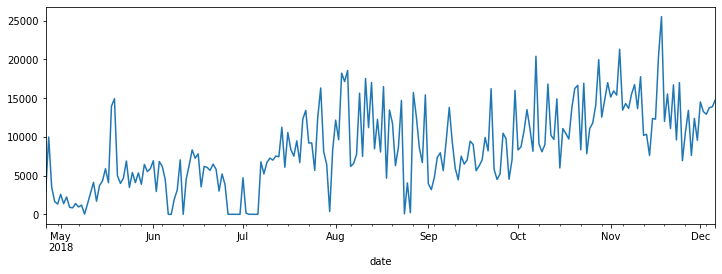

In [37]:
df['steps'].resample("D").mean().plot(figsize=(12,4))

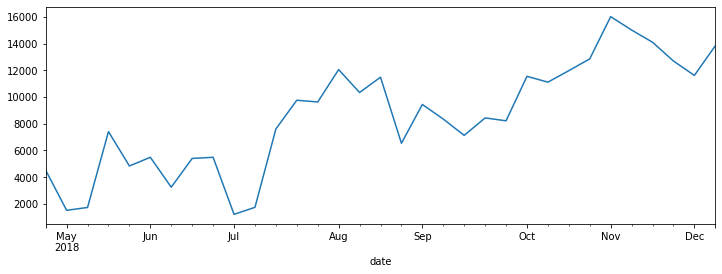

In [36]:
df['steps'].resample("W").mean().plot(figsize=(12,4))

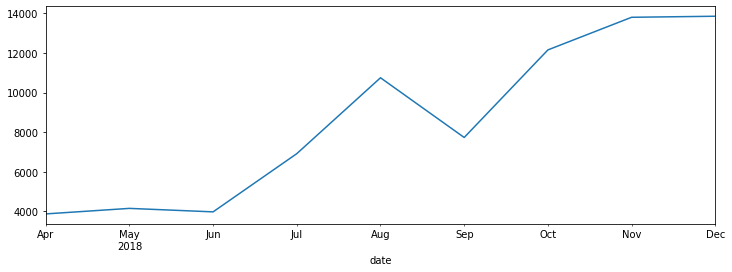

In [35]:
df['steps'].resample("M").mean().plot(figsize=(12,4))

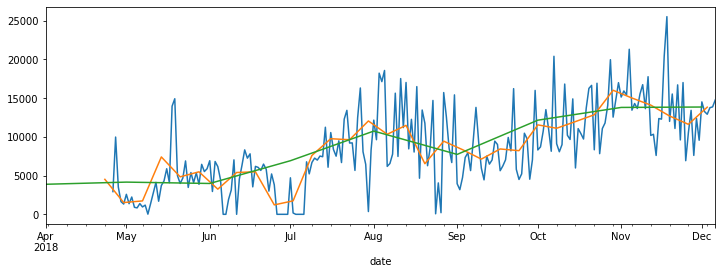

In [57]:
df['steps'].resample("D").mean().plot(figsize=(12,4))
df['steps'].resample("W").mean().plot(figsize=(12,4))
df['steps'].resample("M").mean().plot(figsize=(12,4))

In [40]:
# look for days when there is a zero value
df.steps.sort_values().head(15)

date
2018-06-27      0
2018-07-04      0
2018-07-03      0
2018-06-30      0
2018-06-06      0
2018-06-07      0
2018-06-29      0
2018-06-11      0
2018-06-28      0
2018-07-05      0
2018-07-06      0
2018-06-26      0
2018-05-09     21
2018-08-24     68
2018-07-02    172
Name: steps, dtype: int64

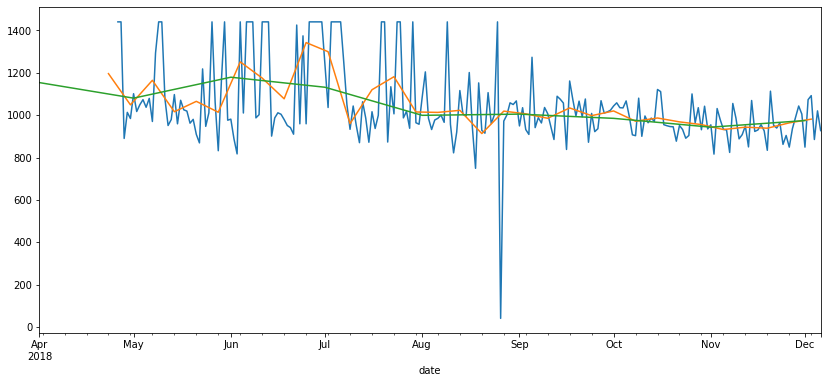

In [83]:
# started off strong in the beginning and then began to fall off the wagon a bit in the end
df['total_minutes_logged'].resample("D").mean().plot(figsize=(14,6))
df['total_minutes_logged'].resample("W").mean().plot(figsize=(14,6))
df['total_minutes_logged'].resample("M").mean().plot(figsize=(14,6))

In [43]:
df.total_minutes_logged.sort_values().head(15)

date
2018-08-26     41
2018-08-18    749
2018-11-02    816
2018-06-03    817
2018-08-11    822
2018-11-07    824
2018-05-28    832
2018-11-19    834
2018-09-16    838
2018-11-26    849
2018-12-01    849
2018-11-13    850
2018-11-24    862
2018-05-22    869
2018-07-12    870
Name: total_minutes_logged, dtype: int64

In [73]:
# which month(s) has lowest amount of logged activity
df1 = df.resample("M").mean()
df1.sort_values(by='total_minutes_logged', ascending=True)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance per step
date,,,,,,,,,,,
2018-11-30,3813.066667,13794.800000,6.620333,24.500000,620.500000,236.900000,19.133333,66.633333,2111.433333,943.166667,0.000480
2018-12-31,3692.166667,13847.333333,6.598333,40.333333,671.333333,219.000000,17.000000,67.000000,2002.500000,974.333333,0.000476
2018-10-31,3574.451613,12149.387097,5.740000,23.032258,705.161290,205.645161,19.032258,54.903226,1779.903226,984.741935,0.000472
2018-08-31,3753.612903,10743.967742,5.075161,12.451613,717.354839,216.419355,13.580645,51.677419,1901.935484,999.032258,0.000472
2018-09-30,3258.833333,7732.100000,3.655000,13.633333,779.100000,185.600000,13.266667,26.733333,1346.866667,1004.700000,0.000472
2018-05-31,3116.032258,4156.032258,1.960000,1.387097,908.483871,151.709677,11.677419,8.225806,984.967742,1080.096774,0.000472
2018-07-31,3317.290323,6916.741935,3.263871,5.935484,920.000000,171.580645,17.483871,22.483871,1331.903226,1131.548387,0.000472
2018-04-30,3067.800000,3877.000000,1.826000,4.600000,995.600000,138.600000,13.600000,5.600000,916.800000,1153.400000,0.000470
2018-06-30,2972.600000,3980.533333,1.878000,3.233333,1012.233333,152.166667,10.000000,4.466667,923.833333,1178.866667,0.000472


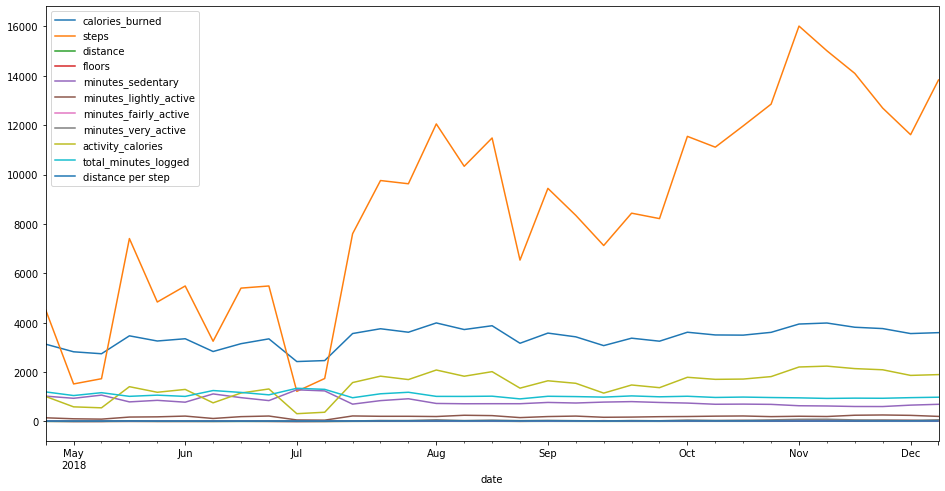

In [75]:
fig = df.resample("W").mean().plot(figsize=(16,8))

In [76]:
df.sort_index().steps.sort_values(ascending=True).head(15)

date
2018-06-27      0
2018-07-04      0
2018-07-03      0
2018-06-30      0
2018-06-06      0
2018-06-07      0
2018-06-29      0
2018-06-11      0
2018-06-28      0
2018-07-05      0
2018-07-06      0
2018-06-26      0
2018-05-09     21
2018-08-24     68
2018-07-02    172
Name: steps, dtype: int64